In [1]:
%%capture
!unzip Project3Data.zip

In [20]:
import pandas as pd

# Look at a sample clinical note
data = pd.read_xml('Project3Data/Project3_data/400-01.xml')

### Vital Signs
The goal is to provide a frequency distribution of the vital signs/physical exam readings observed across the patient clinical notes.

What are the vital signs/physical exams?
*   Blood pressure
*   Pulse
*   Temperature
*   Respitory rate
*   Height
*   Weight
*   Oxygen saturation

Since we are analyzing free-text data that is only semi-structured, I read through a bunch of clinical notes and manually extracted aliases for each vital sign.
*   Blood pressure: ```[Blood pressure, BP]```
*   Pulse: ```[Pulse, P, HR, heart rate]```
*   Temperature: ```[Tempreture, T, Temp]```
*   Respitory rate: ```[Respitory rate, Respirations, RR, Fs]```
*   Height: ```[Height, Ht]```
*   Weight: ```[Wt, wgt, none (only a number followed by 'pounds' or 'lbs'), weighing, W.]```
*   Oxygen saturation: ```[Oxygen saturation, SaO2, O2 saturation, saturating, Sat, O2 sat, O2sat]```

In [23]:
# Extract the name of all the files to be analyzed
file_names = []
with open('Project3Data/Project3_data/MIscellaneous/pl.txt', 'r') as f:
  for file_name in f:
    file_names.append(file_name.rstrip('\n'))
f.close()
file_names[0]

'100-01.xml'

In [4]:
# Define the aliases and regex patterns for each vital sign
patterns = {
    'Blood pressure': r'\b(?:blood pressure|bp)\b(?:(?!\b(?:blood pressure|bp|pulse|p\b|hr|heart rate|temperature|t\b|temp|respiratory rate|respirations|rr|fs|height|ht|wt|weight|weighing|w\.|oxygen saturation|sao2|o2 saturation|saturating|sat|o2 sat)\b).)*?(\d+/\d+)',
    'Pulse': r'\b(?:pulse|p\b|hr|heart rate)\b\s*[:\-]?\s*(\d+)',
    'Temperature': r'\b(?:temperature|t\b|temp)\b(?:(?!\b(?:blood pressure|bp|pulse|p\b|hr|heart rate|temperature|t\b|temp|respiratory rate|respirations|rr|fs|height|ht|wt|weight|weighing|w\.|oxygen saturation|sao2|o2 saturation|saturating|sat|o2 sat)\b).)*?(\d+(?:\.\d+)?)',
    'Respiratory rate': r'\b(?:respiratory rate|respirations|rr|fs)\b(?:(?!\b(?:blood pressure|bp|pulse|p\b|hr|heart rate|temperature|t\b|temp|respiratory rate|respirations|rr|fs|height|ht|wt|weight|weighing|w\.|oxygen saturation|sao2|o2 saturation|saturating|sat|o2 sat)\b).)*?(\d+)',
    'Weight': r'\b(?:wt|wgt|weight|weighing|w\.)\b(?:(?!\b(?:blood pressure|bp|pulse|p\b|hr|heart rate|temperature|t\b|temp|respiratory rate|respirations|rr|fs|height|ht|wt|weight|weighing|w\.|oxygen saturation|sao2|o2 saturation|saturating|sat|o2 sat)\b).)*?(\d+)',
    'Oxygen saturation': r'\b(?:oxygen saturation|sao2|o2 saturation|saturating|sat|o2 sat|o2sat)\b(?:(?!\b(?:blood pressure|bp|pulse|p\b|hr|heart rate|temperature|t\b|temp|respiratory rate|respirations|rr|fs|height|ht|wt|weight|weighing|w\.|oxygen saturation|sao2|o2 saturation|saturating|sat|o2 sat)\b).)*?(\d+%)'
}

In [5]:
# Define the valid ranges for each vital sign
valid_ranges = {
    'Blood pressure': lambda x: 80 <= int(x.split('/')[0]) <= 180 and 40 <= int(x.split('/')[1]) <= 110,
    'Pulse': lambda x: 40 <= int(x) <= 120,
    'Temperature': lambda x: 90 <= float(x) <= 110,
    'Respiratory rate': lambda x: 8 <= int(x) <= 30,
    'Weight': lambda x: 100 <= int(x) <= 400,
    'Oxygen saturation': lambda x: 85 <= int(x.rstrip('%')) <= 100
}

In [6]:
# Function to calculate the median
def calculate_median(values):
    if not values:  # If the list is empty
        return None
    values.sort()
    n = len(values)
    if n == 1:
        return values[0]  # Only one value, return it directly
    elif n % 2 == 1:
        return values[n // 2]  # Odd number of values, return the middle one
    else:
        return (values[n // 2 - 1] + values[n // 2]) / 2  # Even number of values, return the average of the two middle values

In [7]:
import re

vital_signs_data = pd.DataFrame()

for xml_file in file_names:
  data_dict = {'filename': xml_file}
  clinical_note = pd.read_xml(f'Project3Data/Project3_data/{xml_file}')['TEXT'][0]
  for sign, pattern in patterns.items():
    matches = re.findall(pattern, clinical_note, re.IGNORECASE)
    valid_matches = [match for match in matches if valid_ranges[sign](match)]
    if sign == 'Blood pressure':
            # Handle blood pressure separately
            systolic = [int(bp.split('/')[0]) for bp in valid_matches]
            diastolic = [int(bp.split('/')[1]) for bp in valid_matches]
            median_systolic = calculate_median(systolic)
            median_diastolic = calculate_median(diastolic)
            median_bp = f'{round(median_systolic)}/{round(median_diastolic)}' if median_systolic is not None and median_diastolic is not None else None
            data_dict['Blood pressure'] = median_bp
    else:
        # Convert matches to numbers for median calculation
        if valid_matches:
            if sign == 'Oxygen saturation':
                valid_matches = [int(match.rstrip('%')) for match in valid_matches]
            elif sign == 'Temperature':
                valid_matches = [float(match) for match in valid_matches]
            else:
                valid_matches = [int(match) for match in valid_matches]
            median_value = calculate_median(valid_matches)
        else:
            median_value = None
        data_dict[sign] = median_value
  row_df = pd.DataFrame([data_dict])
  vital_signs_data = pd.concat([vital_signs_data, row_df], ignore_index=True)
# Replace None with NaN
vital_signs_data = vital_signs_data.replace(to_replace=[None], value=pd.NA)

In [8]:
vital_signs_data.tail()

,filename,Blood pressure,Pulse,Temperature,Respiratory rate,Weight,Oxygen saturation
1299,400-01.xml,<NA>,100.0,<NA>,<NA>,<NA>,<NA>
1300,400-02.xml,<NA>,81.0,98.3,18,<NA>,100
1301,400-03.xml,168/84,80,<NA>,<NA>,<NA>,<NA>
1302,400-04.xml,120/70,84,<NA>,<NA>,224,<NA>
1303,400-05.xml,176/92,102.0,98.55,21.0,<NA>,97


In [9]:
def missing_percentage(df, column_name):
    missing_count = df[column_name].isna().sum()
    total_count = len(df[column_name])
    missing_percentage = (missing_count / total_count) * 100
    return missing_percentage

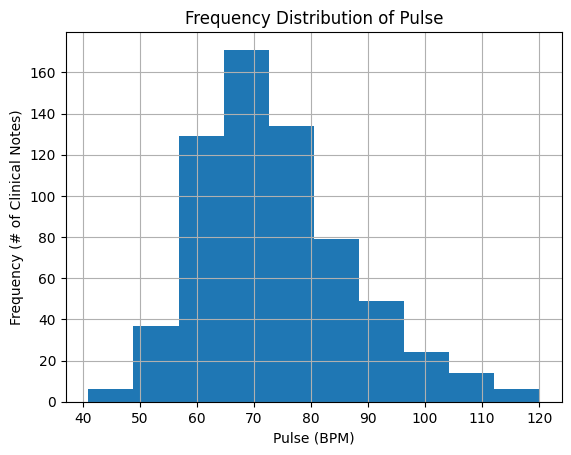

Pulse data was collected for 50.23006134969326% of all clinical notes.


In [11]:
import matplotlib.pyplot as plt

# histogram
vital_signs_data['Pulse'].hist()
plt.title('Frequency Distribution of Pulse')
plt.xlabel('Pulse (BPM)')
plt.ylabel('Frequency (# of Clinical Notes)')
plt.show()

print(f"Pulse data was collected for {missing_percentage(vital_signs_data, 'Pulse')}% of all clinical notes.")

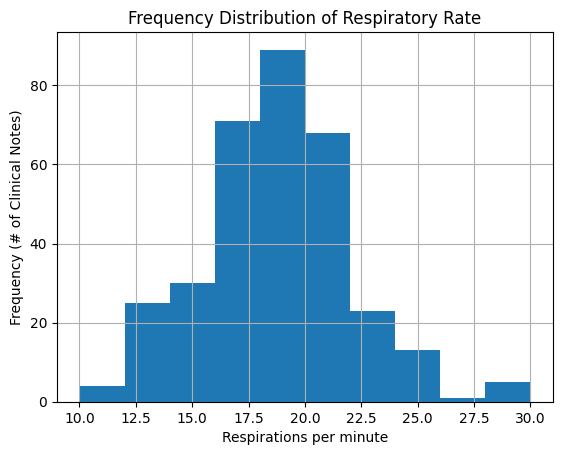

Respiratory rate data was collected for 74.76993865030674% of all clinical notes.


In [12]:
vital_signs_data['Respiratory rate'].hist()
plt.title('Frequency Distribution of Respiratory Rate')
plt.xlabel('Respirations per minute')
plt.ylabel('Frequency (# of Clinical Notes)')
plt.show()

print(f"Respiratory rate data was collected for {missing_percentage(vital_signs_data, 'Respiratory rate')}% of all clinical notes.")

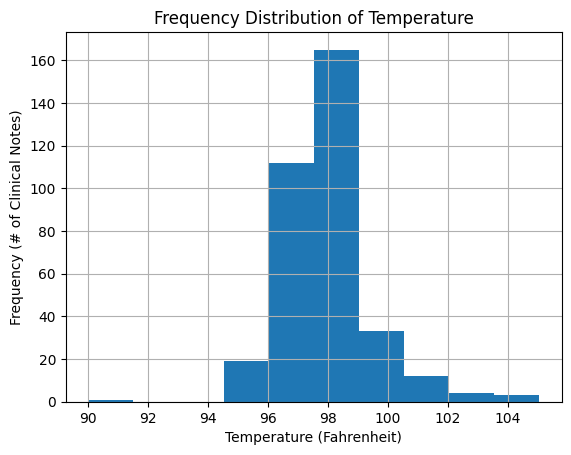

Temperature data was collected for 73.2361963190184% of all clinical notes.


In [13]:
vital_signs_data['Temperature'].hist()
plt.title('Frequency Distribution of Temperature')
plt.xlabel('Temperature (Fahrenheit)')
plt.ylabel('Frequency (# of Clinical Notes)')
plt.show()

print(f"Temperature data was collected for {missing_percentage(vital_signs_data, 'Temperature')}% of all clinical notes.")

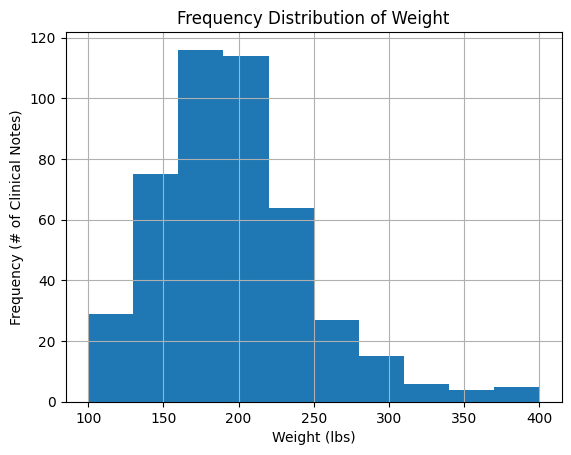

Weight data was collected for 65.10736196319019% of all clinical notes.


In [14]:
vital_signs_data['Weight'].hist()
plt.title('Frequency Distribution of Weight')
plt.xlabel('Weight (lbs)')
plt.ylabel('Frequency (# of Clinical Notes)')
plt.show()

print(f"Weight data was collected for {missing_percentage(vital_signs_data, 'Weight')}% of all clinical notes.")

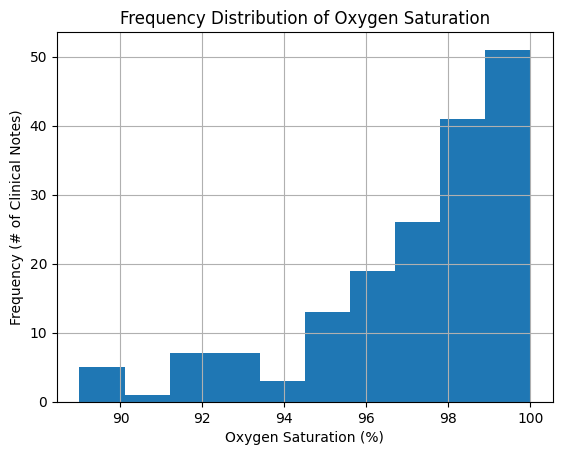

Oxygen saturation data was collected for 86.73312883435584% of all clinical notes.


In [15]:
vital_signs_data['Oxygen saturation'].hist()
plt.title('Frequency Distribution of Oxygen Saturation')
plt.xlabel('Oxygen Saturation (%)')
plt.ylabel('Frequency (# of Clinical Notes)')
plt.show()

print(f"Oxygen saturation data was collected for {missing_percentage(vital_signs_data, 'Oxygen saturation')}% of all clinical notes.")

In [16]:
# Split the 'Blood pressure' column into 'Systolic' and 'Diastolic'
vital_signs_data[['Systolic', 'Diastolic']] = vital_signs_data['Blood pressure'].str.split('/', expand=True)
vital_signs_data['Systolic'] = pd.to_numeric(vital_signs_data['Systolic'], errors='coerce')
vital_signs_data['Diastolic'] = pd.to_numeric(vital_signs_data['Diastolic'], errors='coerce')

In [17]:
# Check if split was done correctly
vital_signs_data.tail()

,filename,Blood pressure,Pulse,Temperature,Respiratory rate,Weight,Oxygen saturation,Systolic,Diastolic
1299,400-01.xml,<NA>,100.0,<NA>,<NA>,<NA>,<NA>,NaN,NaN
1300,400-02.xml,<NA>,81.0,98.3,18,<NA>,100,NaN,NaN
1301,400-03.xml,168/84,80,<NA>,<NA>,<NA>,<NA>,168.0,84.0
1302,400-04.xml,120/70,84,<NA>,<NA>,224,<NA>,120.0,70.0
1303,400-05.xml,176/92,102.0,98.55,21.0,<NA>,97,176.0,92.0


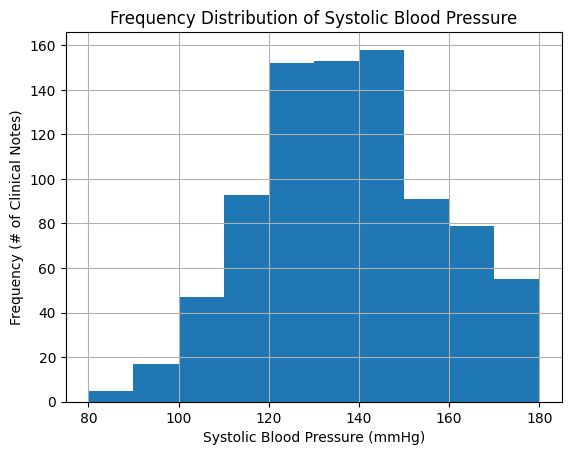

Systolic blood pressure data was collected for 34.8159509202454% of all clinical notes.


In [18]:
vital_signs_data['Systolic'].hist()
plt.title('Frequency Distribution of Systolic Blood Pressure')
plt.xlabel('Systolic Blood Pressure (mmHg)')
plt.ylabel('Frequency (# of Clinical Notes)')
plt.show()

print(f"Systolic blood pressure data was collected for {missing_percentage(vital_signs_data, 'Systolic')}% of all clinical notes.")

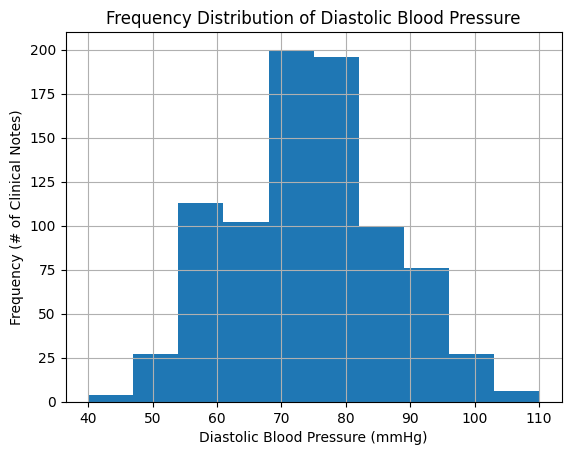

Diastolic blood pressure data was collected for 34.8159509202454% of all clinical notes.


In [19]:
vital_signs_data['Diastolic'].hist()
plt.title('Frequency Distribution of Diastolic Blood Pressure')
plt.xlabel('Diastolic Blood Pressure (mmHg)')
plt.ylabel('Frequency (# of Clinical Notes)')
plt.show()

print(f"Diastolic blood pressure data was collected for {missing_percentage(vital_signs_data, 'Diastolic')}% of all clinical notes.")

### Sentiment Analysis


In [21]:
!pip install textblob

In [32]:
from textblob import TextBlob

sentiments = []
for xml_file in file_names:
  clinical_note = pd.read_xml(f'Project3Data/Project3_data/{xml_file}')['TEXT'][0]
  sentiment = TextBlob(clinical_note).sentiment.polarity
  sentiments.append(sentiment)

vital_signs_data['sentiment'] = sentiments

In [33]:
vital_signs_data.tail()

,filename,Blood pressure,Pulse,Temperature,Respiratory rate,Weight,Oxygen saturation,Systolic,Diastolic,sentiment
1299,400-01.xml,<NA>,100.0,<NA>,<NA>,<NA>,<NA>,NaN,NaN,0.193714
1300,400-02.xml,<NA>,81.0,98.3,18,<NA>,100,NaN,NaN,-0.074853
1301,400-03.xml,168/84,80,<NA>,<NA>,<NA>,<NA>,168.0,84.0,0.060000
1302,400-04.xml,120/70,84,<NA>,<NA>,224,<NA>,120.0,70.0,0.048268
1303,400-05.xml,176/92,102.0,98.55,21.0,<NA>,97,176.0,92.0,-0.001028


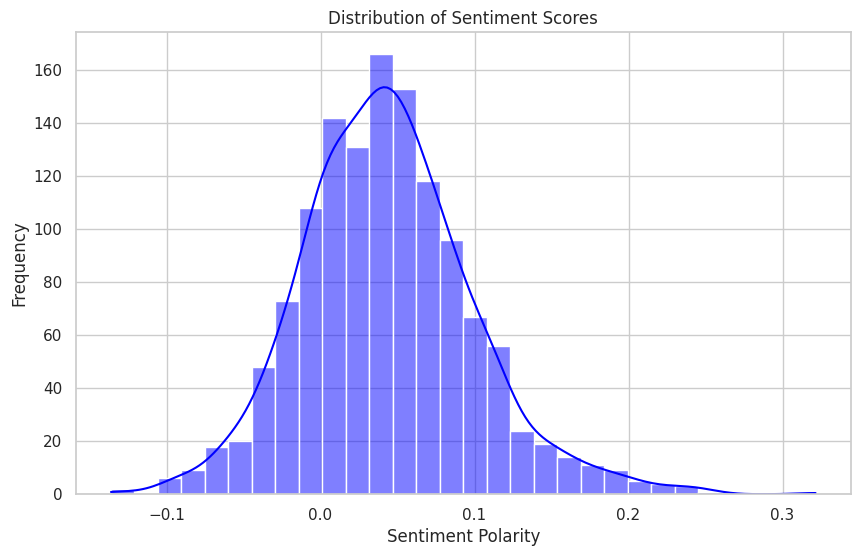

In [34]:
import seaborn as sns

sns.set(style='whitegrid')

plt.figure(figsize=(10, 6))

sns.histplot(vital_signs_data['sentiment'], bins=30, kde=True, color='blue')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')

plt.show()